# <small> <i>Task 8.</small> </i> Columnwise shifted pictures 

* Divide a picture into roughly equal blocks of columns. Each process takes its own block. The number of columns $N$ is not equal to the number of processes $n_p$, i.e., $N \ne n_p$ in general.
* Create $N$ new pictures by cyclically shifting the columns of pixels. E.g., for $N = 3 $: $[c_0, c_1, c_2] \rightarrow [c_2, c_0, c_1] \rightarrow [c_1, c_2, c_0]$

CRITERIA:

1. The number of MPI processors can be chosen arbitrarily, not depending on the picture width (2 points)

2. Plot the speedup vs number of processors (2 points)

3. Plot memory consumption vs number of processors (2 points)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving sleep_deprivation.jpg to sleep_deprivation.jpg


In [2]:
pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185338 sha256=5370757555f1eed40057994b8b48633202e0322d2d0607cb5efa8435bd7ff5fd
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [3]:
%matplotlib inline
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%%writefile parallel_cat.py
import numpy as np
from mpi4py import MPI
import sys
import matplotlib.pyplot as plt
from PIL import Image

#-----MPI-------------------------------
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
#-----open image, choose the number of frames--------
image = np.array(Image.open('sleep_deprivation.jpg'))
image_part=np.array_split(image,size,axis=1)[rank]
N = int(sys.argv[1])
step=image.shape[0]//N
#-----------------------------------------
for i in range(N+1):
    #----shift the rows in image--------------   
    image_temp = image_part.copy()
    image_part[-step:],image_part[0:-step] = image_temp[0:step],image_temp[step:]
    #----gather the image---------------------
    if rank==0:
    image = np.empty((size,image_part.shape[0],image_part.shape[1]+1,image_part.shape[2]))
    image = comm.gather(image_part, root=0)
    #----form the image and save it-------------
    if rank==0:
        image = np.concatenate(image, axis = 1)
        #---------------------------------------
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        plt.axis('off')
        filename = 'cat_%04d.png' % i 
        plt.savefig(filename)


Writing parallel_cat.py


In [12]:
!mpiexec -n 3 --allow-run-as-root python -m mpi4py parallel_cat.py 50

parallel_cat.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


In [13]:
# create a movie

from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob("cat_*.png"))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('movie.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

### speedup vs number of processors

In [ ]:
import time

In [ ]:
T = []
for i in range(1,11):
    t_start = time.time()
    !mpirun -n {i} --allow-run-as-root python -m mpi4py parallel_cat.py 20
    t_end = time.time()
    T.append(t_end-t_start)
    print('Time: {:6.3f}     Processes: {}'.format(T[-1],i))

Time: 11.866     Processes: 1
Time: 17.791     Processes: 2
Time: 23.315     Processes: 3
Time: 33.549     Processes: 4
Time: 41.481     Processes: 5
Time: 50.014     Processes: 6
Time: 58.753     Processes: 7
Time: 65.584     Processes: 8
Time: 76.204     Processes: 9
Time: 81.844     Processes: 10


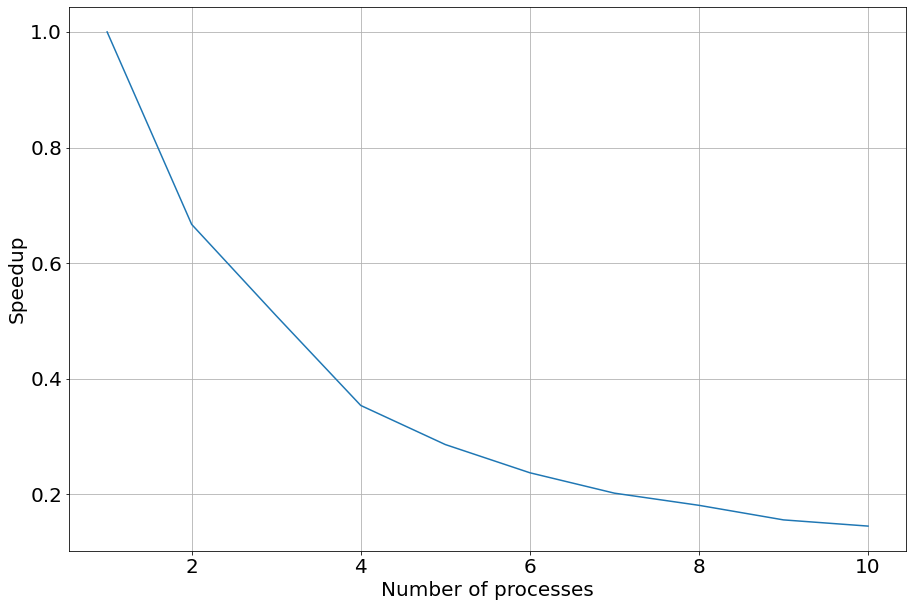

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(range(1,11), [T[0]/i for i in T])
plt.xlabel('Number of processes', fontsize=20)
plt.ylabel('Speedup', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid();

### memory consumption vs number of processors

In [ ]:
pip install psutil

In [ ]:
import tracemalloc
Mem = []
for i in range(1,11):
    tracemalloc.start()
    !mpirun -n {i} --allow-run-as-root python -m mpi4py parallel_cat.py 20
    t_end = time.time()
    Mem.append(tracemalloc.get_traced_memory()[1])
    tracemalloc.stop()
    print('Memory: {:10d} Bytes     Processes: {}'.format(Mem[-1],i))

Memory: 100590.000     Processes: 1
Memory: 69103.000     Processes: 2
Memory: 69480.000     Processes: 3
Memory: 70147.000     Processes: 4
Memory: 70615.000     Processes: 5
Memory: 72301.000     Processes: 6
Memory: 108417.000     Processes: 7
Memory: 72057.000     Processes: 8
Memory: 71202.000     Processes: 9
Memory: 79750.000     Processes: 10


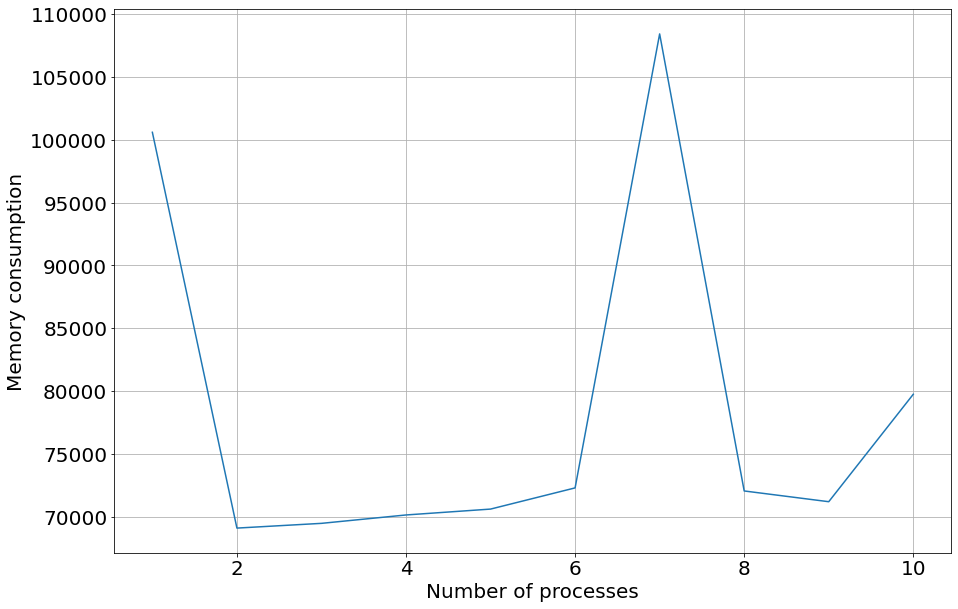

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(1,11), Mem)
plt.xlabel('Number of processes', fontsize=20)
plt.ylabel('Memory consumption', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid();

### Cleaning

In [8]:
!rm -rf cat_*.png

In [9]:
!rm -rf movie.gif